# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will learn how to load and pre-process data from the [COCO dataset](http://cocodataset.org/#home). You will also design a CNN-RNN model for automatically generating image captions.

Note that **any amendments that you make to this notebook will not be graded**.  However, you will use the instructions provided in **Step 3** and **Step 4** to implement your own CNN encoder and RNN decoder by making amendments to the **models.py** file provided as part of this project.  Your **models.py** file **will be graded**. 

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Explore the Data Loader
- [Step 2](#step2): Use the Data Loader to Obtain Batches
- [Step 3](#step3): Experiment with the CNN Encoder
- [Step 4](#step4): Implement the RNN Decoder

<a id='step1'></a>
## Step 1: Explore the Data Loader

We have already written a [data loader](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) that you can use to load the COCO dataset in batches. 

In the code cell below, you will initialize the data loader by using the `get_loader` function in **data_loader.py**.  

> For this project, you are not permitted to change the **data_loader.py** file, which must be used as-is.

The `get_loader` function takes as input a number of arguments that can be explored in **data_loader.py**.  Take the time to explore these arguments now by opening **data_loader.py** in a new window.  Most of the arguments must be left at their default values, and you are only allowed to amend the values of the arguments below:
1. **`transform`** - an [image transform](http://pytorch.org/docs/master/torchvision/transforms.html) specifying how to pre-process the images and convert them to PyTorch tensors before using them as input to the CNN encoder.  For now, you are encouraged to keep the transform as provided in `transform_train`.  You will have the opportunity later to choose your own image transform to pre-process the COCO images.
2. **`mode`** - one of `'train'` (loads the training data in batches) or `'test'` (for the test data). We will say that the data loader is in training or test mode, respectively.  While following the instructions in this notebook, please keep the data loader in training mode by setting `mode='train'`.
3. **`batch_size`** - determines the batch size.  When training the model, this is number of image-caption pairs used to amend the model weights in each training step.
4. **`vocab_threshold`** - the total number of times that a word must appear in the in the training captions before it is used as part of the vocabulary.  Words that have fewer than `vocab_threshold` occurrences in the training captions are considered unknown words. 
5. **`vocab_from_file`** - a Boolean that decides whether to load the vocabulary from file.  

We will describe the `vocab_threshold` and `vocab_from_file` arguments in more detail soon.  For now, run the code cell below.  Be patient - it may take a couple of minutes to run!

In [6]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
!pip install nltk
import nltk
nltk.download('punkt')
from data_loader import get_loader
from torchvision import transforms

# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 5

# Specify the batch size.
batch_size = 10

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
loading annotations into memory...
Done (t=1.18s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=1.09s)
creating index...


  0%|          | 892/414113 [00:00<01:32, 4464.67it/s]

index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [02:05<00:00, 3300.28it/s]


When you ran the code cell above, the data loader was stored in the variable `data_loader`.  

You can access the corresponding dataset as `data_loader.dataset`.  This dataset is an instance of the `CoCoDataset` class in **data_loader.py**.  If you are unfamiliar with data loaders and datasets, you are encouraged to review [this PyTorch tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

### Exploring the `__getitem__` Method

The `__getitem__` method in the `CoCoDataset` class determines how an image-caption pair is pre-processed before being incorporated into a batch.  This is true for all `Dataset` classes in PyTorch; if this is unfamiliar to you, please review [the tutorial linked above](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html). 

When the data loader is in training mode, this method begins by first obtaining the filename (`path`) of a training image and its corresponding caption (`caption`).

#### Image Pre-Processing 

Image pre-processing is relatively straightforward (from the `__getitem__` method in the `CoCoDataset` class):
```python
# Convert image to tensor and pre-process using transform
image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
image = self.transform(image)
```
After loading the image in the training folder with name `path`, the image is pre-processed using the same transform (`transform_train`) that was supplied when instantiating the data loader.  

#### Caption Pre-Processing 

The captions also need to be pre-processed and prepped for training. In this example, for generating captions, we are aiming to create a model that predicts the next token of a sentence from previous tokens, so we turn the caption associated with any image into a list of tokenized words, before casting it to a PyTorch tensor that we can use to train the network.

To understand in more detail how COCO captions are pre-processed, we'll first need to take a look at the `vocab` instance variable of the `CoCoDataset` class.  The code snippet below is pulled from the `__init__` method of the `CoCoDataset` class:
```python
def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, 
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        ...
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        ...
```
From the code snippet above, you can see that `data_loader.dataset.vocab` is an instance of the `Vocabulary` class from **vocabulary.py**.  Take the time now to verify this for yourself by looking at the full code in **data_loader.py**.  

We use this instance to pre-process the COCO captions (from the `__getitem__` method in the `CoCoDataset` class):

```python
# Convert caption to tensor of word ids.
tokens = nltk.tokenize.word_tokenize(str(caption).lower())   # line 1
caption = []                                                 # line 2
caption.append(self.vocab(self.vocab.start_word))            # line 3
caption.extend([self.vocab(token) for token in tokens])      # line 4
caption.append(self.vocab(self.vocab.end_word))              # line 5
caption = torch.Tensor(caption).long()                       # line 6
```

As you will see soon, this code converts any string-valued caption to a list of integers, before casting it to a PyTorch tensor.  To see how this code works, we'll apply it to the sample caption in the next code cell.

In [9]:
sample_caption = 'A person doing a trick on a rail while riding a skateboard.'

In **`line 1`** of the code snippet, every letter in the caption is converted to lowercase, and the [`nltk.tokenize.word_tokenize`](http://www.nltk.org/) function is used to obtain a list of string-valued tokens.  Run the next code cell to visualize the effect on `sample_caption`.

In [10]:
import nltk

sample_tokens = nltk.tokenize.word_tokenize(str(sample_caption).lower())
print(sample_tokens)

['a', 'person', 'doing', 'a', 'trick', 'on', 'a', 'rail', 'while', 'riding', 'a', 'skateboard', '.']


In **`line 2`** and **`line 3`** we initialize an empty list and append an integer to mark the start of a caption.  The [paper](https://arxiv.org/pdf/1411.4555.pdf) that you are encouraged to implement uses a special start word (and a special end word, which we'll examine below) to mark the beginning (and end) of a caption.

This special start word (`"<start>"`) is decided when instantiating the data loader and is passed as a parameter (`start_word`).  You are **required** to keep this parameter at its default value (`start_word="<start>"`).

As you will see below, the integer `0` is always used to mark the start of a caption.

In [11]:
sample_caption = []

start_word = data_loader.dataset.vocab.start_word
print('Special start word:', start_word)
sample_caption.append(data_loader.dataset.vocab(start_word))
print(sample_caption)

Special start word: <start>
[0]


In **`line 4`**, we continue the list by adding integers that correspond to each of the tokens in the caption.

In [12]:
sample_caption.extend([data_loader.dataset.vocab(token) for token in sample_tokens])
print(sample_caption)

[0, 3, 98, 754, 3, 396, 39, 3, 1009, 207, 139, 3, 753, 18]


In **`line 5`**, we append a final integer to mark the end of the caption.  

Identical to the case of the special start word (above), the special end word (`"<end>"`) is decided when instantiating the data loader and is passed as a parameter (`end_word`).  You are **required** to keep this parameter at its default value (`end_word="<end>"`).

As you will see below, the integer `1` is always used to  mark the end of a caption.

In [13]:
end_word = data_loader.dataset.vocab.end_word
print('Special end word:', end_word)

sample_caption.append(data_loader.dataset.vocab(end_word))
print(sample_caption)

Special end word: <end>
[0, 3, 98, 754, 3, 396, 39, 3, 1009, 207, 139, 3, 753, 18, 1]


Finally, in **`line 6`**, we convert the list of integers to a PyTorch tensor and cast it to [long type](http://pytorch.org/docs/master/tensors.html#torch.Tensor.long).  You can read more about the different types of PyTorch tensors on the [website](http://pytorch.org/docs/master/tensors.html).

In [14]:
import torch

sample_caption = torch.Tensor(sample_caption).long()
print(sample_caption)

tensor([    0,     3,    98,   754,     3,   396,    39,     3,  1009,
          207,   139,     3,   753,    18,     1])


And that's it!  In summary, any caption is converted to a list of tokens, with _special_ start and end tokens marking the beginning and end of the sentence:
```
[<start>, 'a', 'person', 'doing', 'a', 'trick', 'while', 'riding', 'a', 'skateboard', '.', <end>]
```
This list of tokens is then turned into a list of integers, where every distinct word in the vocabulary has an associated integer value:
```
[0, 3, 98, 754, 3, 396, 207, 139, 3, 753, 18, 1]
```
Finally, this list is converted to a PyTorch tensor.  All of the captions in the COCO dataset are pre-processed using this same procedure from **`lines 1-6`** described above.  

As you saw, in order to convert a token to its corresponding integer, we call `data_loader.dataset.vocab` as a function.  The details of how this call works can be explored in the `__call__` method in the `Vocabulary` class in **vocabulary.py**.  

```python
def __call__(self, word):
    if not word in self.word2idx:
        return self.word2idx[self.unk_word]
    return self.word2idx[word]
```

The `word2idx` instance variable is a Python [dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) that is indexed by string-valued keys (mostly tokens obtained from training captions).  For each key, the corresponding value is the integer that the token is mapped to in the pre-processing step.

Use the code cell below to view a subset of this dictionary.

In [15]:
# Preview the word2idx dictionary.
dict(list(data_loader.dataset.vocab.word2idx.items())[:10])

{'<start>': 0,
 '<end>': 1,
 '<unk>': 2,
 'a': 3,
 'very': 4,
 'clean': 5,
 'and': 6,
 'well': 7,
 'decorated': 8,
 'empty': 9}

We also print the total number of keys.

In [16]:
# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

Total number of tokens in vocabulary: 8855


As you will see if you examine the code in **vocabulary.py**, the `word2idx` dictionary is created by looping over the captions in the training dataset.  If a token appears no less than `vocab_threshold` times in the training set, then it is added as a key to the dictionary and assigned a corresponding unique integer.  You will have the option later to amend the `vocab_threshold` argument when instantiating your data loader.  Note that in general, **smaller** values for `vocab_threshold` yield a **larger** number of tokens in the vocabulary.  You are encouraged to check this for yourself in the next code cell by decreasing the value of `vocab_threshold` before creating a new data loader.  

In [17]:
# Modify the minimum word count threshold.
vocab_threshold = 5

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

loading annotations into memory...
Done (t=0.92s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...


  0%|          | 765/414113 [00:00<01:47, 3852.49it/s]

Done (t=0.89s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [01:38<00:00, 4208.79it/s]


In [18]:
# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

Total number of tokens in vocabulary: 8855


There are also a few special keys in the `word2idx` dictionary.  You are already familiar with the special start word (`"<start>"`) and special end word (`"<end>"`).  There is one more special token, corresponding to unknown words (`"<unk>"`).  All tokens that don't appear anywhere in the `word2idx` dictionary are considered unknown words.  In the pre-processing step, any unknown tokens are mapped to the integer `2`.

In [19]:
unk_word = data_loader.dataset.vocab.unk_word
print('Special unknown word:', unk_word)

print('All unknown words are mapped to this integer:', data_loader.dataset.vocab(unk_word))

Special unknown word: <unk>
All unknown words are mapped to this integer: 2


Check this for yourself below, by pre-processing the provided nonsense words that never appear in the training captions. 

In [20]:
print(data_loader.dataset.vocab('jfkafejw'))
print(data_loader.dataset.vocab('ieowoqjf'))

2
2


The final thing to mention is the `vocab_from_file` argument that is supplied when creating a data loader.  To understand this argument, note that when you create a new data loader, the vocabulary (`data_loader.dataset.vocab`) is saved as a [pickle](https://docs.python.org/3/library/pickle.html) file in the project folder, with filename `vocab.pkl`.

If you are still tweaking the value of the `vocab_threshold` argument, you **must** set `vocab_from_file=False` to have your changes take effect.  

But once you are happy with the value that you have chosen for the `vocab_threshold` argument, you need only run the data loader *one more time* with your chosen `vocab_threshold` to save the new vocabulary to file.  Then, you can henceforth set `vocab_from_file=True` to load the vocabulary from file and speed the instantiation of the data loader.  Note that building the vocabulary from scratch is the most time-consuming part of instantiating the data loader, and so you are strongly encouraged to set `vocab_from_file=True` as soon as you are able.

Note that if `vocab_from_file=True`, then any supplied argument for `vocab_threshold` when instantiating the data loader is completely ignored.

In [21]:
# Obtain the data loader (from file). Note that it runs much faster than before!
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_from_file=True)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...


100%|██████████| 414113/414113 [01:36<00:00, 4278.31it/s]


Done (t=1.13s)
creating index...
index created!
Obtaining caption lengths...


In the next section, you will learn how to use the data loader to obtain batches of training data.

<a id='step2'></a>
## Step 2: Use the Data Loader to Obtain Batches

The captions in the dataset vary greatly in length.  You can see this by examining `data_loader.dataset.caption_lengths`, a Python list with one entry for each training caption (where the value stores the length of the corresponding caption).  

In the code cell below, we use this list to print the total number of captions in the training data with each length.  As you will see below, the majority of captions have length 10.  Likewise, very short and very long captions are quite rare.  

In [22]:
from collections import Counter

# Tally the total number of training captions with each length.
counter = Counter(data_loader.dataset.caption_lengths)
lengths = sorted(counter.items(), key=lambda pair: pair[1], reverse=True)
for value, count in lengths:
    print('value: %2d --- count: %5d' % (value, count))

value: 10 --- count: 86334
value: 11 --- count: 79948
value:  9 --- count: 71934
value: 12 --- count: 57637
value: 13 --- count: 37645
value: 14 --- count: 22335
value:  8 --- count: 20771
value: 15 --- count: 12841
value: 16 --- count:  7729
value: 17 --- count:  4842
value: 18 --- count:  3104
value: 19 --- count:  2014
value:  7 --- count:  1597
value: 20 --- count:  1451
value: 21 --- count:   999
value: 22 --- count:   683
value: 23 --- count:   534
value: 24 --- count:   383
value: 25 --- count:   277
value: 26 --- count:   215
value: 27 --- count:   159
value: 28 --- count:   115
value: 29 --- count:    86
value: 30 --- count:    58
value: 31 --- count:    49
value: 32 --- count:    44
value: 34 --- count:    39
value: 37 --- count:    32
value: 33 --- count:    31
value: 35 --- count:    31
value: 36 --- count:    26
value: 38 --- count:    18
value: 39 --- count:    18
value: 43 --- count:    16
value: 44 --- count:    16
value: 48 --- count:    12
value: 45 --- count:    11
v

To generate batches of training data, we begin by first sampling a caption length (where the probability that any length is drawn is proportional to the number of captions with that length in the dataset).  Then, we retrieve a batch of size `batch_size` of image-caption pairs, where all captions have the sampled length.  This approach for assembling batches matches the procedure in [this paper](https://arxiv.org/pdf/1502.03044.pdf) and has been shown to be computationally efficient without degrading performance.

Run the code cell below to generate a batch.  The `get_train_indices` method in the `CoCoDataset` class first samples a caption length, and then samples `batch_size` indices corresponding to training data points with captions of that length.  These indices are stored below in `indices`.

These indices are supplied to the data loader, which then is used to retrieve the corresponding data points.  The pre-processed images and captions in the batch are stored in `images` and `captions`.

In [23]:
import numpy as np
import torch.utils.data as data

# Randomly sample a caption length, and sample indices with that length.
indices = data_loader.dataset.get_train_indices()
print('sampled indices:', indices)

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
data_loader.batch_sampler.sampler = new_sampler
    
# Obtain the batch.
images, captions = next(iter(data_loader))
    
print('images.shape:', images.shape)
print('captions.shape:', captions.shape)

# (Optional) Uncomment the lines of code below to print the pre-processed images and captions.
# print('images:', images)
# print('captions:', captions)

sampled indices: [378290, 273399, 347165, 154771, 257071, 5894, 282786, 391044, 5850, 86450]
images.shape: torch.Size([10, 3, 224, 224])
captions.shape: torch.Size([10, 16])


In [24]:
import matplotlib.pyplot as plt

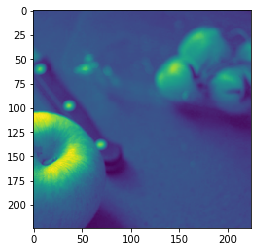

In [25]:
plt.imshow(images[9][0])

In [26]:
captions[9]

tensor([    0,     3,  1451,    13,  2280,    86,     3,  1438,     6,
           47,   156,    39,     3,   112,    18,     1])

Each time you run the code cell above, a different caption length is sampled, and a different batch of training data is returned.  Run the code cell multiple times to check this out!

You will train your model in the next notebook in this sequence (**2_Training.ipynb**). This code for generating training batches will be provided to you.

> Before moving to the next notebook in the sequence (**2_Training.ipynb**), you are strongly encouraged to take the time to become very familiar with the code in  **data_loader.py** and **vocabulary.py**.  **Step 1** and **Step 2** of this notebook are designed to help facilitate a basic introduction and guide your understanding.  However, our description is not exhaustive, and it is up to you (as part of the project) to learn how to best utilize these files to complete the project.  __You should NOT amend any of the code in either *data_loader.py* or *vocabulary.py*.__

In the next steps, we focus on learning how to specify a CNN-RNN architecture in PyTorch, towards the goal of image captioning.

<a id='step3'></a>
## Step 3: Experiment with the CNN Encoder

Run the code cell below to import `EncoderCNN` and `DecoderRNN` from **model.py**. 

In [27]:
# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

# Import EncoderCNN and DecoderRNN. 
from model import EncoderCNN, DecoderRNN

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Run the code cell below to instantiate the CNN encoder in `encoder`.  

The pre-processed images from the batch in **Step 2** of this notebook are then passed through the encoder, and the output is stored in `features`.

In [29]:
# Specify the dimensionality of the image embedding.
embed_size = 256

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Initialize the encoder. (Optional: Add additional arguments if necessary.)
encoder = EncoderCNN(embed_size)

# Move the encoder to GPU if CUDA is available.
encoder.to(device)
    
# Move last batch of images (from Step 2) to GPU if CUDA is available.   
images = images.to(device)

# Pass the images through the encoder.
features = encoder(images)

print('type(features):', type(features))
print('features.shape:', features.shape)

# Check that your encoder satisfies some requirements of the project! :D
assert type(features)==torch.Tensor, "Encoder output needs to be a PyTorch Tensor." 
assert (features.shape[0]==batch_size) & (features.shape[1]==embed_size), "The shape of the encoder output is incorrect."

type(features): <class 'torch.Tensor'>
features.shape: torch.Size([10, 256])


The encoder that we provide to you uses the pre-trained ResNet-50 architecture (with the final fully-connected layer removed) to extract features from a batch of pre-processed images.  The output is then flattened to a vector, before being passed through a `Linear` layer to transform the feature vector to have the same size as the word embedding.

![Encoder](images/encoder.png)

You are welcome (and encouraged) to amend the encoder in **model.py**, to experiment with other architectures.  In particular, consider using a [different pre-trained model architecture](http://pytorch.org/docs/master/torchvision/models.html).  You may also like to [add batch normalization](http://pytorch.org/docs/master/nn.html#normalization-layers).  

> You are **not** required to change anything about the encoder.

For this project, you **must** incorporate a pre-trained CNN into your encoder.  Your `EncoderCNN` class must take `embed_size` as an input argument, which will also correspond to the dimensionality of the input to the RNN decoder that you will implement in Step 4.  When you train your model in the next notebook in this sequence (**2_Training.ipynb**), you are welcome to tweak the value of `embed_size`.

If you decide to modify the `EncoderCNN` class, save **model.py** and re-execute the code cell above.  If the code cell returns an assertion error, then please follow the instructions to modify your code before proceeding.  The assert statements ensure that `features` is a PyTorch tensor with shape `[batch_size, embed_size]`.

<a id='step4'></a>
## Step 4: Implement the RNN Decoder

Before executing the next code cell, you must write `__init__` and `forward` methods in the `DecoderRNN` class in **model.py**.  (Do **not** write the `sample` method yet - you will work with this method when you reach **3_Inference.ipynb**.)

> The `__init__` and `forward` methods in the `DecoderRNN` class are the only things that you **need** to modify as part of this notebook.  You will write more implementations in the notebooks that appear later in the sequence.

Your decoder will be an instance of the `DecoderRNN` class and must accept as input:
- the PyTorch tensor `features` containing the embedded image features (outputted in Step 3, when the last batch of images from Step 2 was passed through `encoder`), along with
- a PyTorch tensor corresponding to the last batch of captions (`captions`) from Step 2.

Note that the way we have written the data loader should simplify your code a bit.  In particular, every training batch will contain pre-processed captions where all have the same length (`captions.shape[1]`), so **you do not need to worry about padding**.  
> While you are encouraged to implement the decoder described in [this paper](https://arxiv.org/pdf/1411.4555.pdf), you are welcome to implement any architecture of your choosing, as long as it uses at least one RNN layer, with hidden dimension `hidden_size`.  

Although you will test the decoder using the last batch that is currently stored in the notebook, your decoder should be written to accept an arbitrary batch (of embedded image features and pre-processed captions [where all captions have the same length]) as input.  

![Decoder](images/decoder.png)

In the code cell below, `outputs` should be a PyTorch tensor with size `[batch_size, captions.shape[1], vocab_size]`.  Your output should be designed such that `outputs[i,j,k]` contains the model's predicted score, indicating how likely the `j`-th token in the `i`-th caption in the batch is the `k`-th token in the vocabulary.  In the next notebook of the sequence (**2_Training.ipynb**), we provide code to supply these scores to the [`torch.nn.CrossEntropyLoss`](http://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss) optimizer in PyTorch.

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Specify the number of features in the hidden state of the RNN decoder.
hidden_size = 512

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Store the size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the decoder.
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move the decoder to GPU if CUDA is available.
decoder.to(device)
    
# Move last batch of captions (from Step 1) to GPU if CUDA is available 
captions = captions.to(device)

# Pass the encoder output and captions through the decoder.
outputs = decoder(features, captions)

print('type(outputs):', type(outputs))
print('outputs.shape:', outputs.shape)

# Check that your decoder satisfies some requirements of the project! :D
assert type(outputs)==torch.Tensor, "Decoder output needs to be a PyTorch Tensor."
assert (outputs.shape[0]==batch_size) & (outputs.shape[1]==captions.shape[1]) & (outputs.shape[2]==vocab_size), "The shape of the decoder output is incorrect."

type(outputs): <class 'torch.Tensor'>
outputs.shape: torch.Size([10, 16, 8855])


When you train your model in the next notebook in this sequence (**2_Training.ipynb**), you are welcome to tweak the value of `hidden_size`.